<center><h1>1-ab: Introduction to Neural Networks</h1></center>

<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>

# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


In [55]:
#!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/2-ab.zip
#!unzip -j 2-ab.zip
#!wget https://github.com/rdfia/rdfia.github.io/raw/master/code/2-ab/utils-data.py

In [56]:
import math
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%run 'utils-data.py'

# Part 1 : Forward and backward passes "by hands"

In [57]:
def init_params(nx, nh, ny):
    """
    nx, nh, ny: integers
    out params: dictionnary
    """
    params = {}

    #####################
    ## Your code here  ##
    #####################
    # fill values for Wh, Wy, bh, by

    params["Wh"] = torch.randn(nh,nx)
    params["Wy"] = torch.randn(ny,nh)
    params["bh"] = torch.zeros(1,nh)
    params["by"] = torch.zeros(1,ny)

    ####################
    ##      END        #
    ####################
    return params

In [58]:
def forward(params, X):
    """
    params: dictionnary
    X: (n_batch, dimension)
    """
    bsize = X.size(0)
    nh = params['Wh'].size(0)
    ny = params['Wy'].size(0)
    outputs = {}

    #####################
    ## Your code here  ##
    #####################
    # fill values for X, htilde, h, ytilde, yhat

    m = torch.nn.Softmax(dim=1)

    outputs["X"] = X.clone().detach()
    outputs["htilde"] = X@torch.t(params['Wh']) + params['bh'].repeat(bsize,1)
    outputs["h"] = torch.tanh(outputs['htilde'])
    outputs["ytilde"] = outputs['h']@torch.t(params['Wy'])+params['by'].repeat(bsize,1)
    outputs["yhat"] = m(outputs['ytilde'])

    ####################
    ##      END        #
    ####################

    return outputs['yhat'], outputs

In [59]:
def loss_accuracy(Yhat, Y):

    #####################
    ## Your code here  ##
    #####################

    L = torch.mean(
        - torch.sum(Y*Yhat,dim=1)
        + torch.log(torch.sum(torch.exp(Yhat),dim=1))
        )
    
    _,indsY = torch.max(Y,1)
    _,indsYhat = torch.max(Yhat,1)

    acc = 100 * torch.mean((indsY == indsYhat).float())    

    ####################
    ##      END        #
    ####################

    return L, acc

In [60]:
def backward(params, outputs, Y):
    bsize = Y.shape[0]
    grads = {}

    #####################
    ## Your code here  ##
    #####################
    # fill values for Wy, Wh, by, bh

    delta_y_tilde = outputs['yhat']-Y
    delta_h_tilde = (delta_y_tilde@params['Wy'])*(1-torch.square(outputs['h']))
    grads["Wy"] = torch.t(delta_y_tilde)@outputs['h']
    grads["Wh"] = torch.t(delta_h_tilde)@outputs['X']
    grads["by"] = torch.sum(delta_y_tilde,dim=0,keepdim=True)  # Shape: (1, ny=2)
    grads["bh"] = torch.sum(delta_h_tilde,dim=0,keepdim=True)  # Shape: (1, nh=10)
    ####################
    ##      END        #
    ####################
    return grads

In [61]:
def sgd(params, grads, eta):

    #####################
    ## Your code here  ##
    #####################
    # update the params values

    params["Wh"] = params['Wh'] - grads['Wh'] * eta 
    params["Wy"] = params['Wy'] - grads['Wy'] * eta
    params["bh"] = params['bh'] - grads['bh'] * eta
    params["by"] = params['by'] - grads['by'] * eta

    ####################
    ##      END        #
    ####################
    return params

## Global learning procedure "by hands"

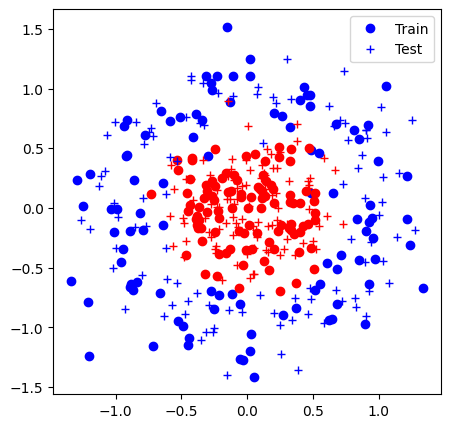

Iter 0: Acc train 65.5% (0.64), acc test 67.5% (0.64)


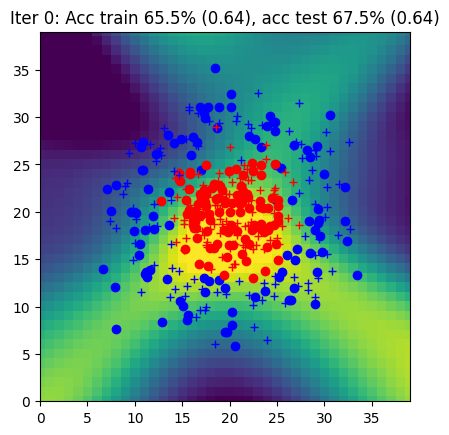

Iter 1: Acc train 71.0% (0.60), acc test 70.0% (0.60)


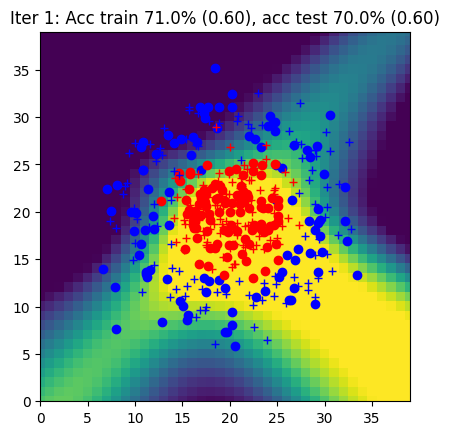

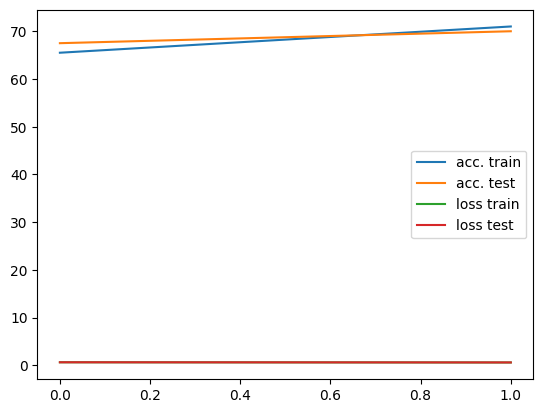

In [62]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

params = init_params(nx, nh, ny)

curves = [[],[], [], []]

# epoch
for iteration in range(2):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #####################
    ## Your code here  ##
    #####################
    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # write the optimization algorithm on the batch (X,Y)
        # using the functions: forward, loss_accuracy, backward, sgd
        Yhat, outputs = forward(params,X)
        L, acc = loss_accuracy(Yhat, Y)
        grads = backward(params, outputs, Y)
        params = sgd(params, grads, eta)
        

    ####################
    ##      END        #
    ####################


    Yhat_train, _ = forward(params, data.Xtrain)
    Yhat_test, _ = forward(params, data.Xtest)
    Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)
    Ygrid, _ = forward(params, data.Xgrid)

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    print(title)
    data.plot_data_with_grid(Ygrid, title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()

# Part 2 : Simplification of the backward pass with `torch.autograd`



In [63]:
def init_params(nx, nh, ny):
    """
    nx, nh, ny: integers
    out params: dictionnary
    """
    params = {}

    #####################
    ## Your code here  ##
    #####################
    # fill values for Wh, Wy, bh, by
    # activaye autograd on the network weights

    params["Wh"] = torch.randn(nh,nx, requires_grad=True)
    params["Wy"] = torch.randn(ny,nh, requires_grad=True)
    params["bh"] = torch.zeros(1,nh, requires_grad=True)
    params["by"] = torch.zeros(1,ny, requires_grad=True)
    ####################
    ##      END        #
    ####################
    return params

The function `forward` remains unchanged from previous part.

The function `backward` is no longer used because of "autograd".

In [64]:
def sgd(params, eta):

    #####################
    ## Your code here  ##
    #####################
    # update the network weights
    # warning: use torch.no_grad()
    # and reset to zero the gradient accumulators
    
    with torch.no_grad():
        params["Wh"] -= eta * params['Wh'].grad
        params["Wy"] -= eta * params['Wy'].grad
        params["bh"] -= eta * params['bh'].grad
        params["by"] -= eta * params['by'].grad

        params['Wh'].grad.zero_()
        params['Wy'].grad.zero_()
        params['bh'].grad.zero_()
        params['by'].grad.zero_()
    ####################
    ##      END        #
    ####################
    return params

## Global learning procedure with autograd

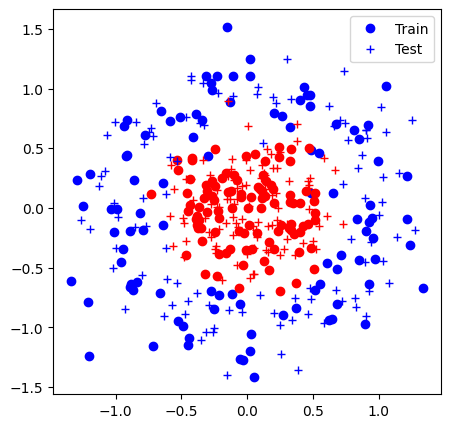

Iter 0: Acc train 53.0% (0.70), acc test 57.0% (0.71)


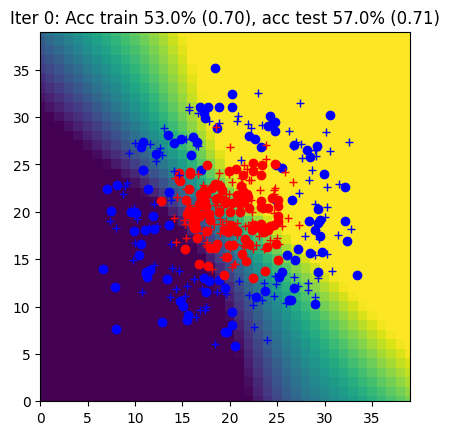

Iter 1: Acc train 59.5% (0.70), acc test 58.5% (0.70)


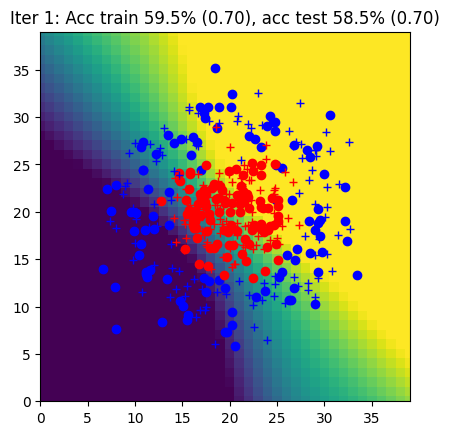

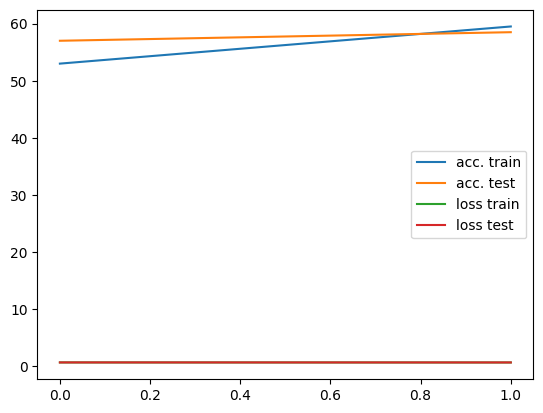

In [65]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

params = init_params(nx, nh, ny)

curves = [[],[], [], []]

# epoch
for iteration in range(2):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #####################
    ## Your code here  ##
    #####################
    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # write the optimization algorithm on the batch (X,Y)
        # using the functions: forward, loss_accuracy, sgd
        # and the backward function with autograd
        Yhat, outputs = forward(params,X)
        L, _ = loss_accuracy(Yhat, Y)
        L.backward()
        params = sgd(params, eta)


    ####################
    ##      END        #
    ####################


    Yhat_train, _ = forward(params, data.Xtrain)
    Yhat_test, _ = forward(params, data.Xtest)
    Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)
    Ygrid, _ = forward(params, data.Xgrid)

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    print(title)
    # detach() is used to remove the predictions from the computational graph in autograd
    data.plot_data_with_grid(Ygrid.detach(), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

with torch.no_grad():
    fig = plt.figure()
    plt.plot(curves[0], label="acc. train")
    plt.plot(curves[1], label="acc. test")
    plt.plot(curves[2], label="loss train")
    plt.plot(curves[3], label="loss test")
    plt.legend()
    plt.show()



# Part 3 : Simplification of the forward pass with `torch.nn`

`init_params` and `forward` are replaced by the `init_model` function which defines the network architecture and the loss.

In [66]:
def init_model(nx, nh, ny):

    #####################
    ## Your code here  ##
    #####################

    model = torch.nn.Sequential(
        torch.nn.Linear(nx, nh),
        torch.nn.Tanh(),
        torch.nn.Linear(nh, ny),
    )
    loss = torch.nn.CrossEntropyLoss()

    ####################
    ##      END        #
    ####################

    return model, loss

In [67]:
def loss_accuracy(loss, Yhat, Y):

    #####################
    ## Your code here  ##
    #####################
    # call the loss function

    L = loss(Yhat, Y)
    _,indsY = torch.max(Y,1)
    _,indsYhat = torch.max(Yhat,1)

    acc = 100 * torch.mean((indsY == indsYhat).float()) 

    ####################
    ##      END        #
    ####################

    return L, acc

In [68]:
def sgd(model, eta):

    #####################
    ## Your code here  ##
    #####################
    # update the network weights
    # warning: use torch.no_grad()
    # and reset to zero the gradient accumulators
    with torch.no_grad():
        for param in model.parameters():
            param -= eta * param.grad
        model.zero_grad()

    ####################
    ##      END        #
    ####################
    return model

## Global learning procedure with autograd and `torch.nn`

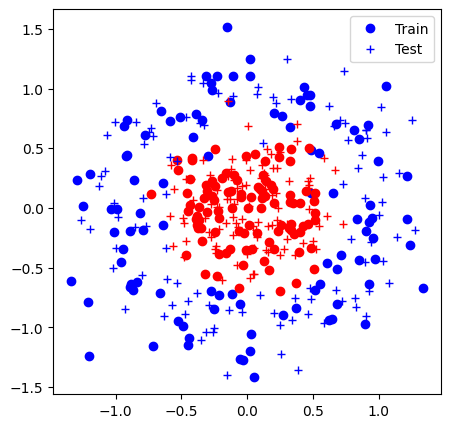

Iter 0: Acc train 54.0% (0.70), acc test 58.0% (0.70)


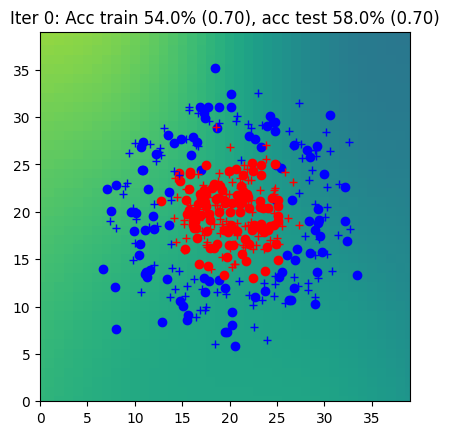

Iter 15: Acc train 88.0% (0.56), acc test 84.0% (0.57)


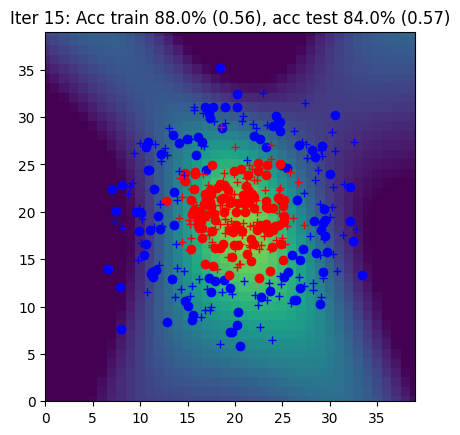

Iter 30: Acc train 97.0% (0.30), acc test 94.5% (0.32)


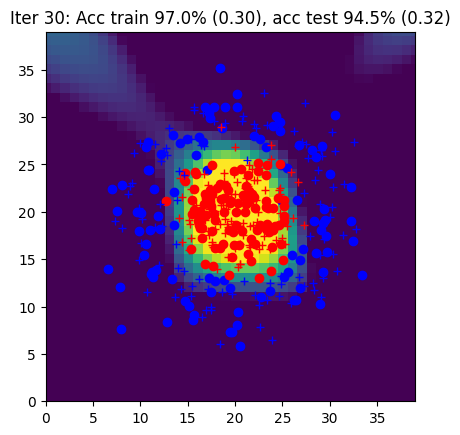

Iter 45: Acc train 96.0% (0.20), acc test 95.0% (0.23)


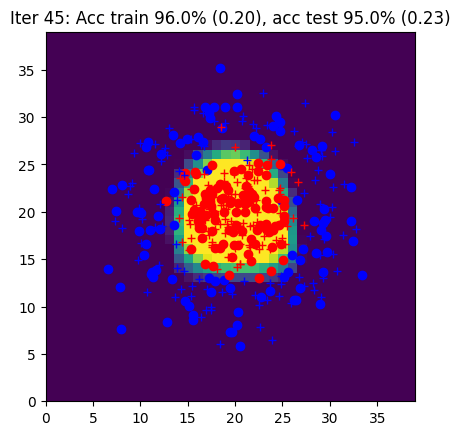

Iter 60: Acc train 96.0% (0.16), acc test 95.0% (0.19)


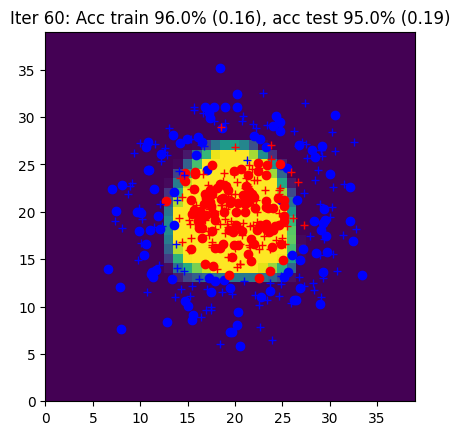

Iter 75: Acc train 96.0% (0.14), acc test 95.0% (0.17)


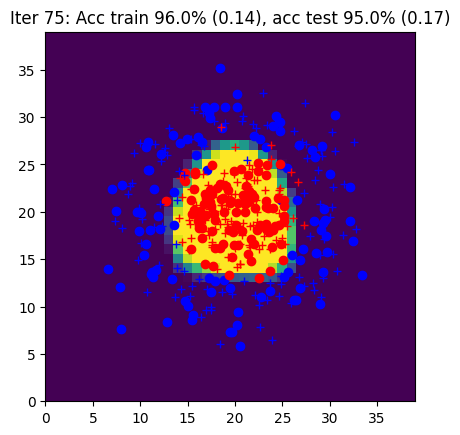

Iter 90: Acc train 96.0% (0.13), acc test 95.0% (0.16)


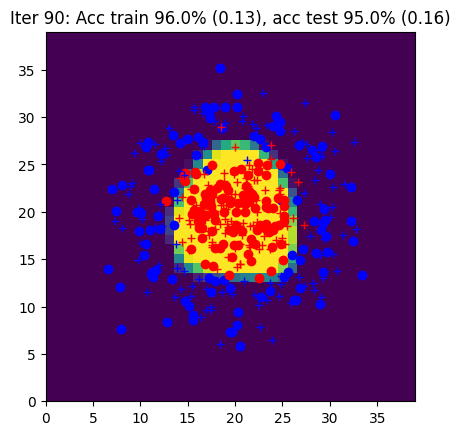

Iter 105: Acc train 95.5% (0.13), acc test 95.0% (0.16)


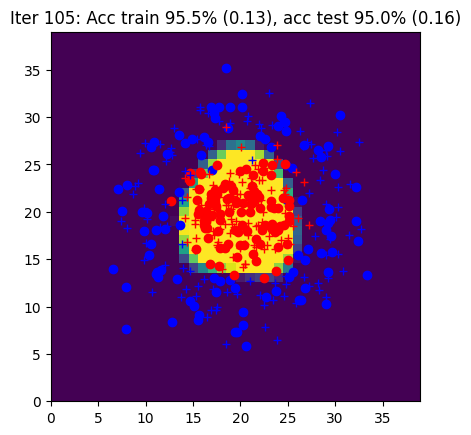

Iter 120: Acc train 96.5% (0.12), acc test 94.5% (0.15)


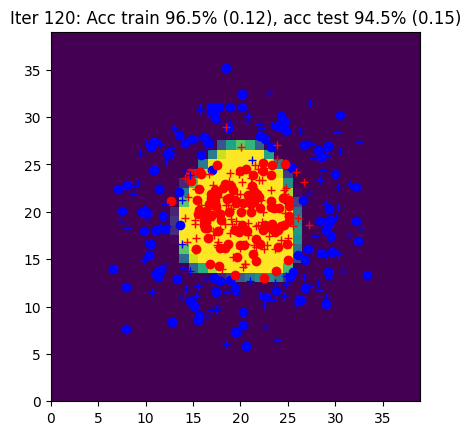

Iter 135: Acc train 97.0% (0.11), acc test 94.5% (0.15)


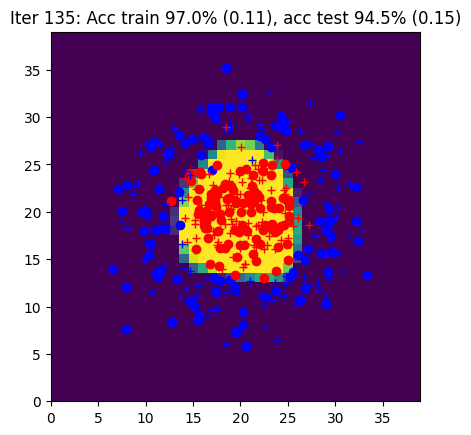

Iter 150: Acc train 97.0% (0.11), acc test 94.5% (0.15)


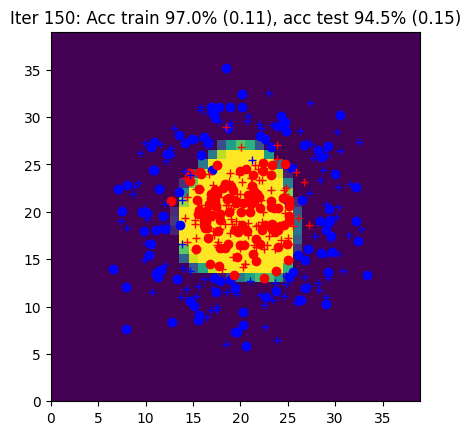

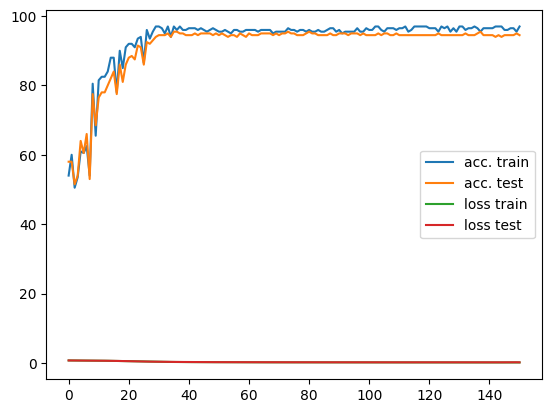

In [ ]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.1

model, loss = init_model(nx, nh, ny)

curves = [[],[], [], []]

# epoch
for iteration in range(151):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #####################
    ## Your code here  ##
    #####################
    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # write the optimization algorithm on the batch (X,Y)
        # using the functions: loss_accuracy, sgd
        # the forward with the predict method from the model
        # and the backward function with autograd
        Yhat = model(X)
        L,acc = loss_accuracy(loss, Yhat, Y)
        L.backward()
        model = sgd(model, eta)
        

    ####################
    ##      END        #
    ####################


    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)
    Ygrid = model(data.Xgrid)


    if not iteration % 15:    
        title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
        print(title)
        data.plot_data_with_grid(torch.nn.Softmax(dim=1)(Ygrid.detach()), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)
with torch.no_grad():
    fig = plt.figure()
    plt.plot(curves[0], label="acc. train")
    plt.plot(curves[1], label="acc. test")
    plt.plot(curves[2], label="loss train")
    plt.plot(curves[3], label="loss test")
    plt.legend()
    plt.show()

# Part 4 : Simplification of the SGD with `torch.optim`

In [73]:
def init_model(nx, nh, ny, eta):

    #####################
    ## Your code here  ##
    #####################
    model = torch.nn.Sequential(
            torch.nn.Linear(nx, nh),
            torch.nn.Tanh(),
            torch.nn.Linear(nh, ny),
    )
    loss = torch.nn.CrossEntropyLoss()
    optim = torch.optim.SGD(model.parameters(), lr=eta)

    ####################
    ##      END        #
    ####################

    return model, loss, optim

The `sgd` function is replaced by calling the `optim.zero_grad()` before the backward and `optim.step()` after.

## Algorithme global d'apprentissage (avec autograd, les couches `torch.nn` et `torch.optim`)

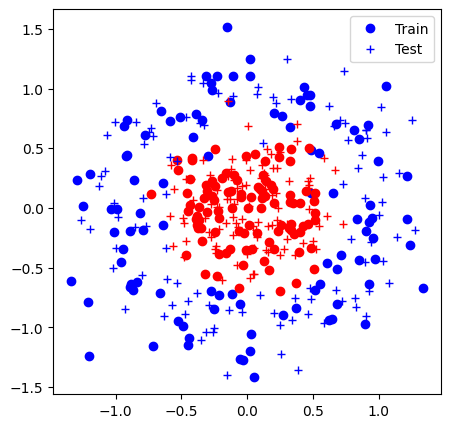

Iter 0: Acc train 61.5% (0.70), acc test 61.5% (0.70)


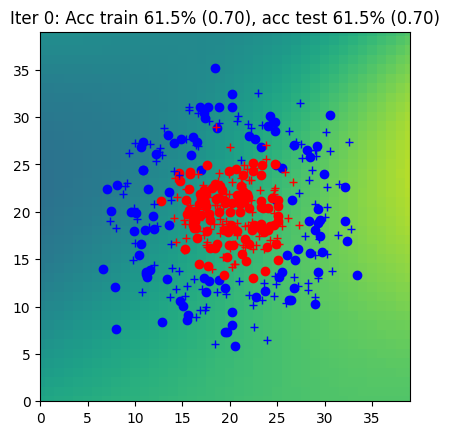

Iter 15: Acc train 70.5% (0.68), acc test 67.0% (0.68)


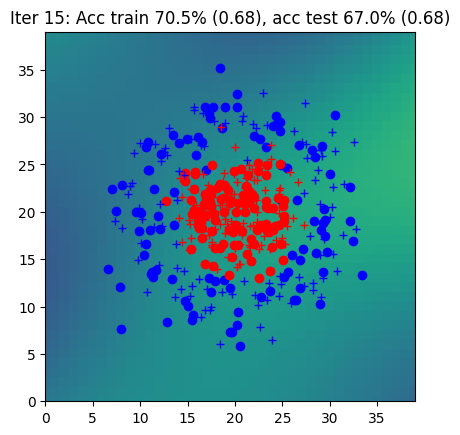

Iter 30: Acc train 81.0% (0.65), acc test 78.5% (0.65)


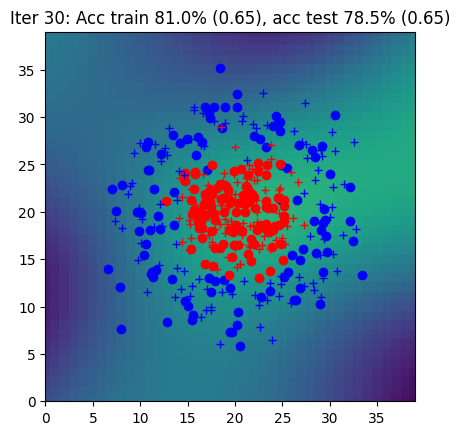

Iter 45: Acc train 87.0% (0.59), acc test 87.5% (0.59)


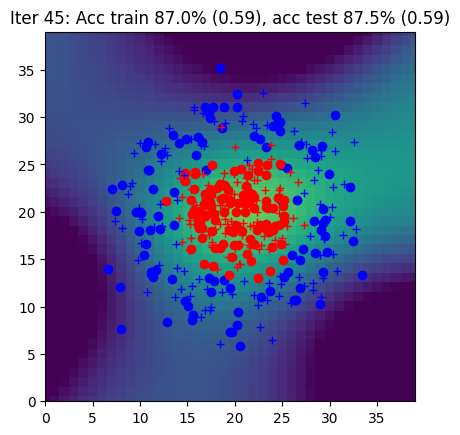

Iter 60: Acc train 89.5% (0.50), acc test 89.5% (0.50)


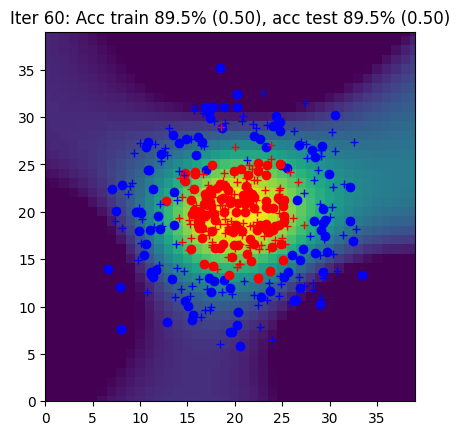

Iter 75: Acc train 94.0% (0.40), acc test 94.5% (0.41)


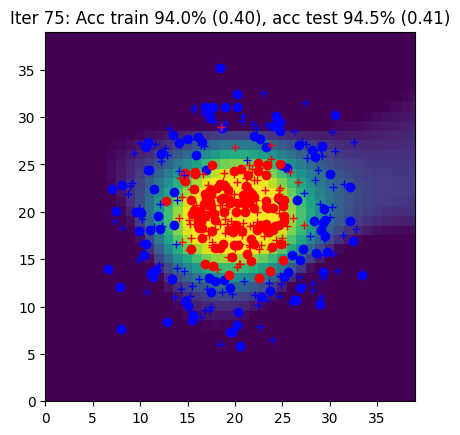

Iter 90: Acc train 96.0% (0.33), acc test 94.5% (0.33)


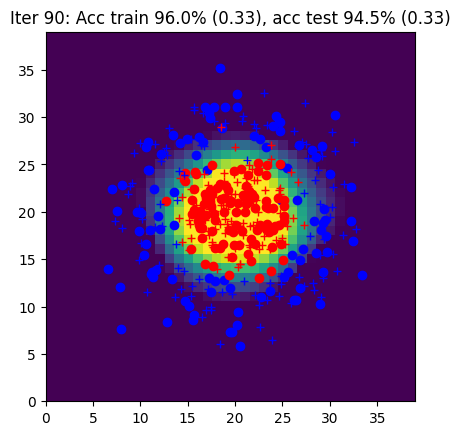

Iter 105: Acc train 95.5% (0.27), acc test 94.5% (0.28)


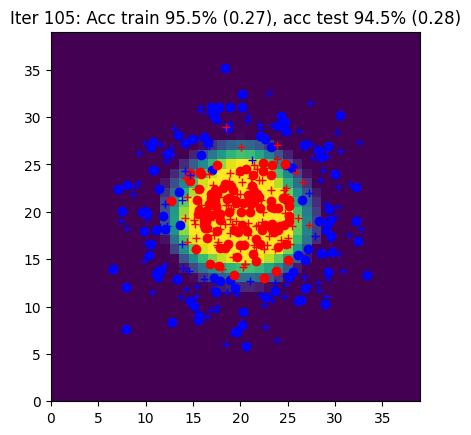

Iter 120: Acc train 95.5% (0.24), acc test 94.5% (0.25)


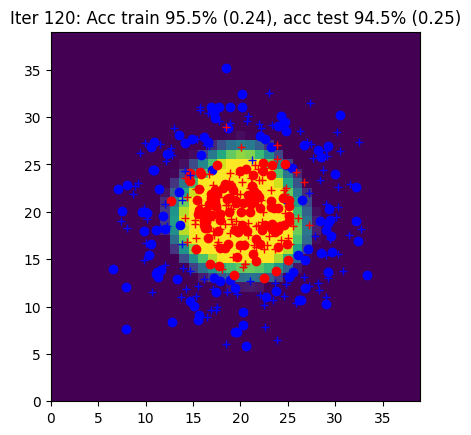

Iter 135: Acc train 96.0% (0.21), acc test 95.0% (0.22)


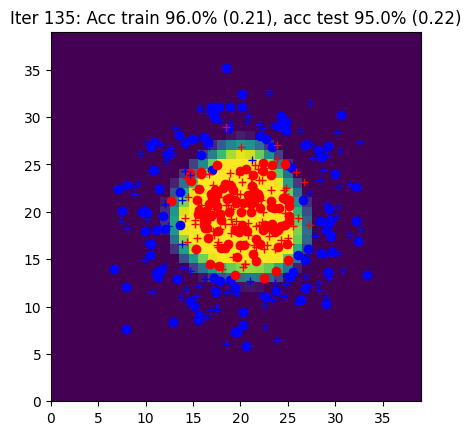

Iter 150: Acc train 95.5% (0.20), acc test 95.0% (0.20)


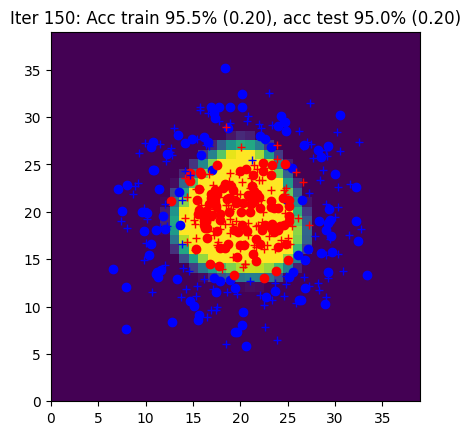

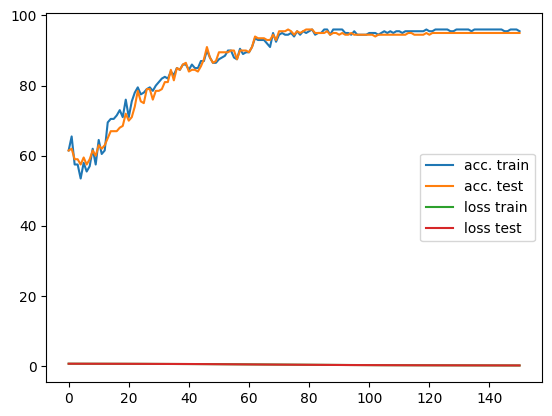

In [53]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

model, loss, optim = init_model(nx, nh, ny, eta)

curves = [[],[], [], []]

# epoch
for iteration in range(151):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #####################
    ## Your code  here ##
    #####################
    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # write the optimization algorithm on the batch (X,Y)
        # using the functions: loss_accuracy
        # the forward with the predict method from the model
        # the backward function with autograd
        # and then an optimization step
        Yhat = model(X)
        L,acc = loss_accuracy(loss, Yhat, Y)
        optim.zero_grad()
        L.backward()
        optim.step()

    ####################
    ##      FIN        #
    ####################


    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)
    Ygrid = model(data.Xgrid)

    if not iteration%15:
        title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
        print(title)
        data.plot_data_with_grid(torch.nn.Softmax(dim=1)(Ygrid.detach()), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)
with torch.no_grad():
    fig = plt.figure()
    plt.plot(curves[0], label="acc. train")
    plt.plot(curves[1], label="acc. test")
    plt.plot(curves[2], label="loss train")
    plt.plot(curves[3], label="loss test")
    plt.legend()
    plt.show()

# Part 5 : MNIST

Apply the code from previous part code to the MNIST dataset.

Iter 0: Acc train 85.6% (0.52), acc test 85.7% (0.51)
Iter 1: Acc train 87.1% (0.46), acc test 87.6% (0.45)
Iter 2: Acc train 86.5% (0.47), acc test 86.4% (0.46)
Iter 3: Acc train 87.0% (0.44), acc test 87.3% (0.43)
Iter 4: Acc train 86.6% (0.45), acc test 87.4% (0.43)
Iter 5: Acc train 88.8% (0.37), acc test 89.3% (0.36)
Iter 6: Acc train 88.8% (0.39), acc test 89.6% (0.38)
Iter 7: Acc train 87.9% (0.39), acc test 88.2% (0.39)
Iter 8: Acc train 87.2% (0.41), acc test 87.9% (0.40)
Iter 9: Acc train 87.6% (0.41), acc test 87.9% (0.39)
Iter 10: Acc train 88.4% (0.38), acc test 88.7% (0.38)
Iter 11: Acc train 87.5% (0.41), acc test 87.7% (0.41)
Iter 12: Acc train 87.7% (0.40), acc test 87.6% (0.41)
Iter 13: Acc train 89.1% (0.37), acc test 89.4% (0.36)
Iter 14: Acc train 89.2% (0.36), acc test 89.6% (0.34)
Iter 15: Acc train 89.1% (0.36), acc test 89.3% (0.36)
Iter 16: Acc train 89.7% (0.34), acc test 89.9% (0.33)
Iter 17: Acc train 89.2% (0.35), acc test 89.1% (0.35)
Iter 18: Acc train 8

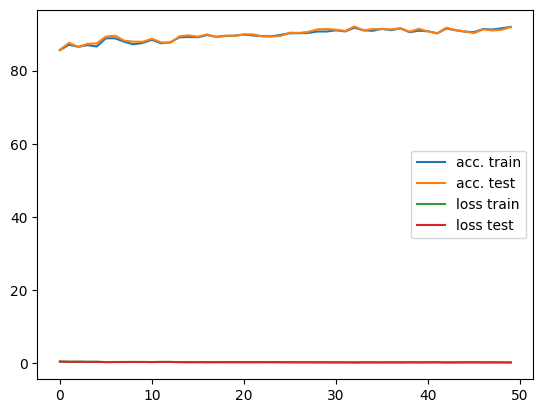

In [ ]:
# init
data = MNISTData()
N = data.Xtrain.shape[0]
Nbatch = 100
nx = data.Xtrain.shape[1]
nh = 100
ny = data.Ytrain.shape[1]
eta = 0.03

model, loss, optim = init_model(nx, nh, ny, eta)

curves = [[],[], [], []]

# epoch
for iteration in range(50):

    # permute
    perm = np.randomx.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #####################
    ## Your code  here ##
    #####################
    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # write the optimization algorithm on the batch (X,Y)
        # using the functions: loss_accuracy
        # the forward with the predict method from the model
        # the backward function with autograd
        # and then an optimization step
        Yhat = model(X)
        L,acc = loss_accuracy(loss, Yhat, Y)
        optim.zero_grad()
        L.backward()
        optim.step()

    ####################
    ##      FIN        #
    ####################


    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)


    Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)
    #Ygrid = model(data.Xgrid)

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    print(title)
     #   data.plot_data_with_grid(torch.nn.Softmax(dim=1)(Ygrid.detach()), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)
with torch.no_grad():
    fig = plt.figure()
    plt.plot(curves[0], label="acc. train")
    plt.plot(curves[1], label="acc. test")
    plt.plot(curves[2], label="loss train")
    plt.plot(curves[3], label="loss test")
    plt.legend()
    plt.show()

/tmp/ipykernel_10076/2467843400.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 10000 + 1) instead
  uniform_dist = np.random.random_integers(0,len(Yhat_test),len(axes.flat))


[8853 2355 1729 2615 7161 5990 2702 9599 2881 6392 3387 2787 1908  860
 8229 8660 7909 6040 4948 5419 6185 2214 8995 5111 1909 1675 5810 4108
 3943  121 5509 4339 2377 9570 2221 1988 6223 8445 4351 5643 7262 9482
 3219 5806 9383 8240 8835 5583 5026 5371 9028 9605 8065  676 4732 9837
 9926 5416 2282 7703 2313 5033 3849 7846  564 4659 6847 2687 4978 2445
 3721 4737 7800 2908 7854]


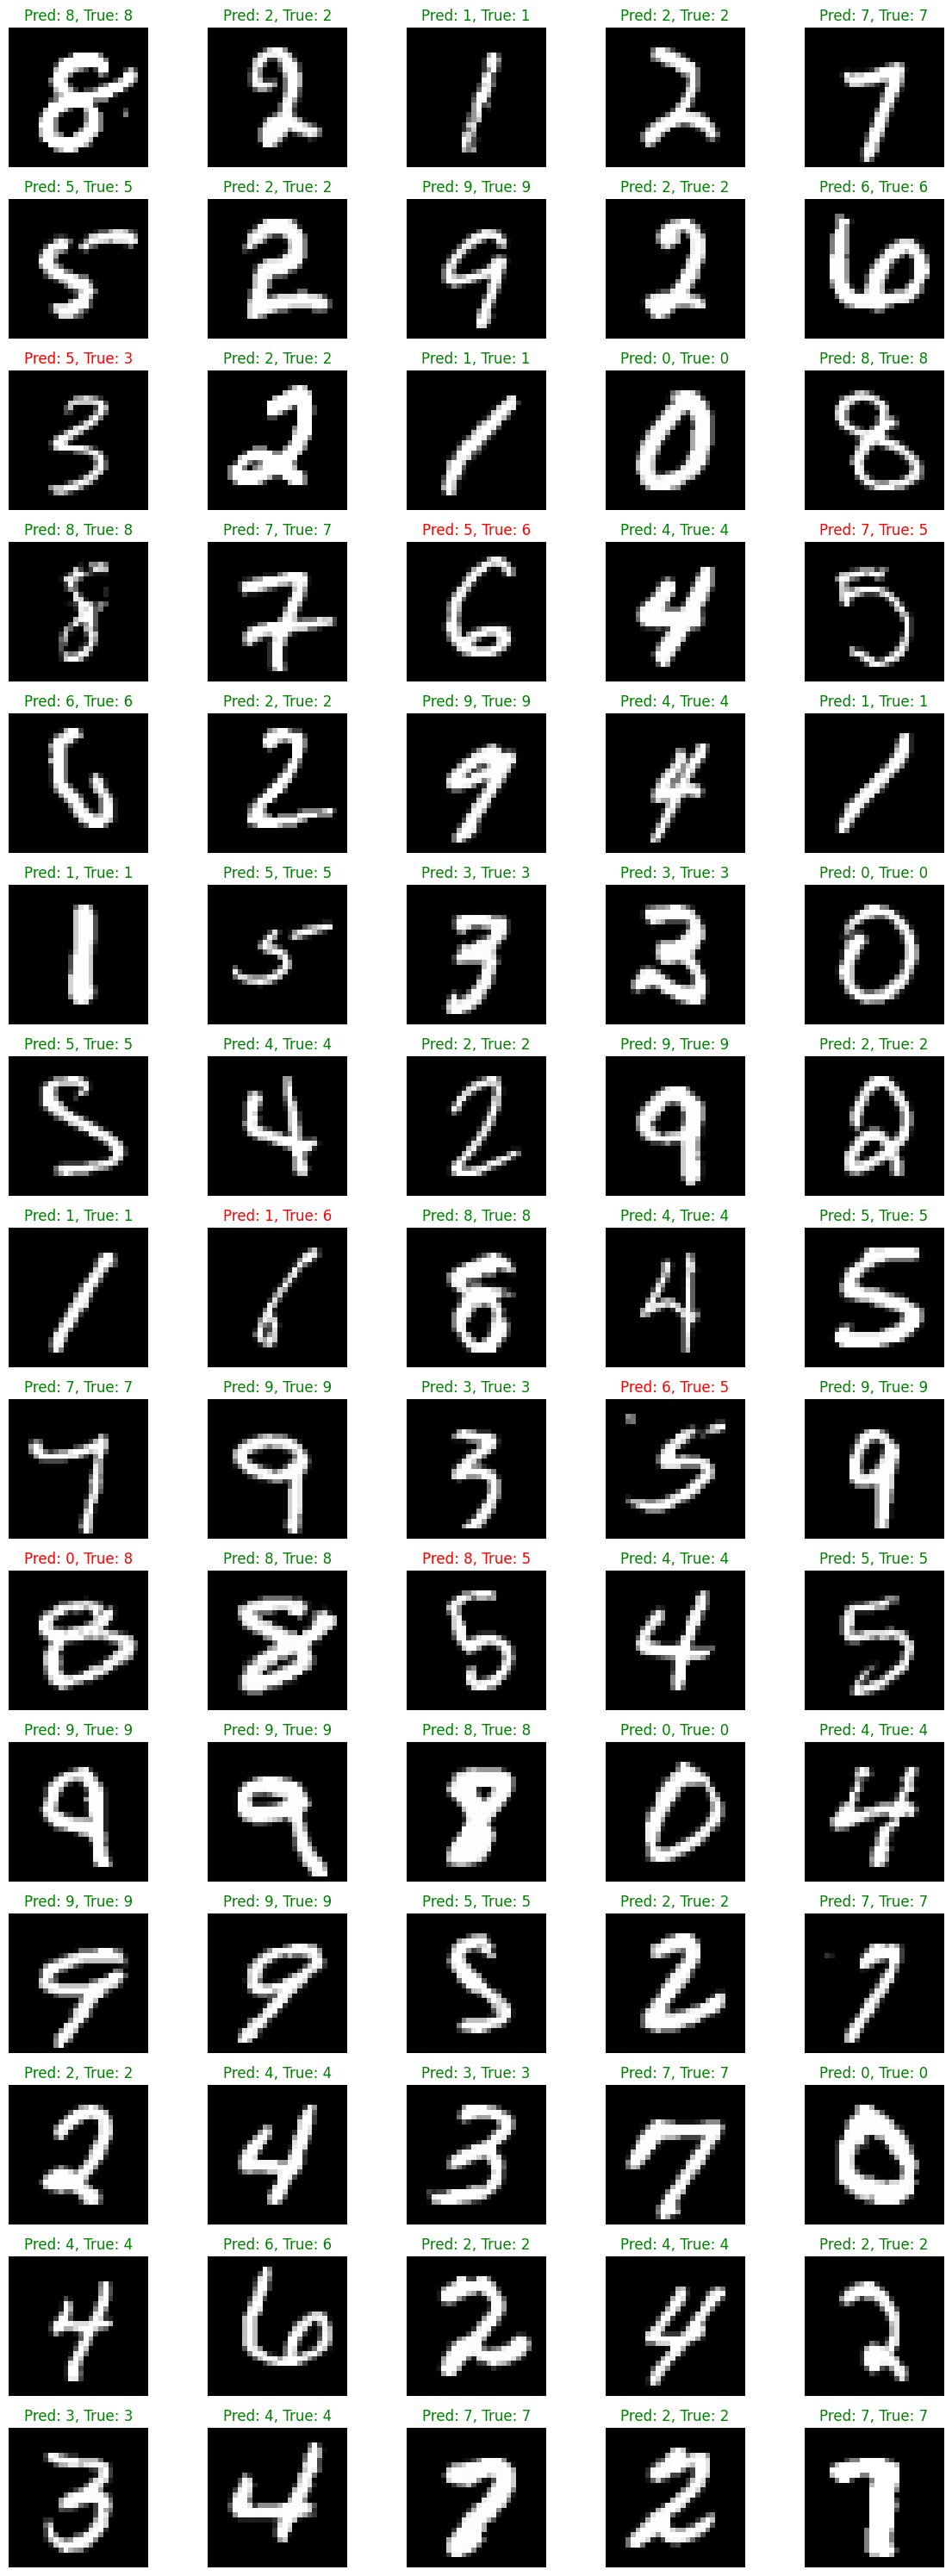

In [ ]:
import numpy as np
fig, axes = plt.subplots(15, 5, figsize=(12,30))
uniform_dist = np.random.random_integers(0,len(Yhat_test),len(axes.flat))
print(uniform_dist)
for i, ax in enumerate(axes.flat):
    sample_i = uniform_dist[i]
    ax.imshow(data.Xtest[sample_i].reshape(28,28), cmap='gray')
    color = 'green' if Yhat_test[sample_i].argmax() == data.Ytest[sample_i].argmax() else 'red'
    ax.set_title(f"Pred: {Yhat_test[sample_i].argmax()}, True: {data.Ytest[sample_i].argmax()}", color=color)
    ax.axis('off')
plt.tight_layout()
plt.show()

# Part 6: Bonus: SVM


Train a SVM model on the Circles dataset.

Ideas :
- First try a linear SVM (sklearn.svm.LinearSVC dans scikit-learn). Does it work well ? Why ?
- Then try more complex kernels (sklearn.svm.SVC). Which one is the best ? why ?
- Does the parameter C of regularization have an impact? Why ?

In [ ]:
# data
data = CirclesData()
Xtrain = data.Xtrain.numpy()
Ytrain = data.Ytrain[:, 0].numpy()

Xgrid = data.Xgrid.numpy()

Xtest = data.Xtest.numpy()
Ytest = data.Ytest[:, 0].numpy()

def plot_svm_predictions(data, predictions):
      plt.figure(2)
      plt.clf()
      plt.imshow(np.reshape(predictions, (40,40)))
      plt.plot(data._Xtrain[data._Ytrain[:,0] == 1,0]*10+20, data._Xtrain[data._Ytrain[:,0] == 1,1]*10+20, 'bo', label="Train")
      plt.plot(data._Xtrain[data._Ytrain[:,1] == 1,0]*10+20, data._Xtrain[data._Ytrain[:,1] == 1,1]*10+20, 'ro')
      plt.plot(data._Xtest[data._Ytest[:,0] == 1,0]*10+20, data._Xtest[data._Ytest[:,0] == 1,1]*10+20, 'b+', label="Test")
      plt.plot(data._Xtest[data._Ytest[:,1] == 1,0]*10+20, data._Xtest[data._Ytest[:,1] == 1,1]*10+20, 'r+')
      plt.xlim(0,39)
      plt.ylim(0,39)
      plt.clim(0.3,0.7)
      plt.draw()
      plt.pause(1e-3)

In [ ]:
import sklearn.svm

############################
### Your code here   #######
### Train the SVM    #######
## See https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
## and https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
############################

svm = None

###########################

In [ ]:
## Print results

Ytest_pred = svm.predict(Xtest)
accuracy = np.sum(Ytest == Ytest_pred) / len(Ytest)
print(f"Accuracy : {100 * accuracy:.2f}")
Ygrid_pred = svm.predict(Xgrid)
plot_svm_predictions(data, Ygrid_pred)